In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("powerplant_data.csv")

In [3]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [4]:
# AT => temperature
# V => vacuum
# AP => pressure
# RH => humidity

# PE => produced energy

In [5]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [6]:
X = df.drop("PE", axis=1)
y = df["PE"]

In [8]:
y.head()

0    480.48
1    445.75
2    438.76
3    453.09
4    464.43
Name: PE, dtype: float64

In [9]:
# Split out data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
df.shape

(9568, 5)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
X_test_scaled

array([[ 1.34499288,  0.23869298, -1.28658067, -1.10532538],
       [ 0.81095912,  1.36269098, -0.74140656,  0.26485915],
       [-0.2437241 , -0.73900436,  1.99970178, -0.19713193],
       ...,
       [-0.67068342, -1.15902881, -0.29951077, -0.10651852],
       [ 1.31420898,  1.33752097, -0.87346737, -0.44288647],
       [-0.2611237 , -0.27021304,  0.37433797,  1.10646548]])

In [21]:
import torch
import torch.nn as nn

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [17]:
type(X_train_scaled)

numpy.ndarray

In [19]:
type(y_train)
y_train.shape

(7654,)

In [22]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

### Deep Learning

In [37]:
# Define our ANN Model

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()

        self.model = nn.Sequential(
            # 1st hidden layer
            nn.Linear(X_train.shape[1], 6),
            nn.ReLU(),
    
            # 2nd hidden layer
            nn.Linear(6, 6),
            nn.ReLU(),
    
            # output layer
            nn.Linear(6, 1),
        )

    def forward(self, x):
        return self.model(x)

In [38]:
import torch.optim as optim

model = ANN()

# loss, optimizer
crietrion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [39]:
# Train the ANN
train_losses = []
val_losses = []

best_val_loss = float("inf")

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0 # tot training loss for 1 epoch
    
    for xb, yb in train_loader:
        # xb = features of 1 batch
        # yb = labels of 1 batch
        optimizer.zero_grad()
        
        outputs = model(xb) # forward prop....predicted outputs for this batch
        loss = crietrion(outputs, yb) # compute loss
        loss.backward() # back prop.. compute gradients
        optimizer.step() # params update
        
        running_loss += loss.item() # loss is a tensor => py float

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)


    # Validation
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad(): # no gradients compute
        for xb, yb in test_loader:
            outputs = model(xb)
            loss = crietrion(outputs, yb)
            running_val_loss += loss

    epoch_val_loss = running_val_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"epoch {epoch+1}/{epochs} ==> train loss = {epoch_train_loss} & val loss = {epoch_val_loss}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), "best_model.pt") #.pt or .pth

epoch 1/100 ==> train loss = 205210.53587239582 & val loss = 202218.359375
epoch 2/100 ==> train loss = 192462.64342447917 & val loss = 177220.265625
epoch 3/100 ==> train loss = 154838.64986979167 & val loss = 132122.9375
epoch 4/100 ==> train loss = 114779.88611653647 & val loss = 103561.3046875
epoch 5/100 ==> train loss = 97416.89554036458 & val loss = 93339.859375
epoch 6/100 ==> train loss = 87287.4866048177 & val loss = 81805.7578125
epoch 7/100 ==> train loss = 71739.04807942708 & val loss = 60436.81640625
epoch 8/100 ==> train loss = 42941.13274739583 & val loss = 25417.322265625
epoch 9/100 ==> train loss = 11337.722127278646 & val loss = 2865.592529296875
epoch 10/100 ==> train loss = 948.7635262807211 & val loss = 276.0196838378906
epoch 11/100 ==> train loss = 172.16597531636555 & val loss = 125.4949951171875
epoch 12/100 ==> train loss = 104.0682506720225 & val loss = 88.84603118896484
epoch 13/100 ==> train loss = 79.75079668362936 & val loss = 69.8272933959961
epoch 14/

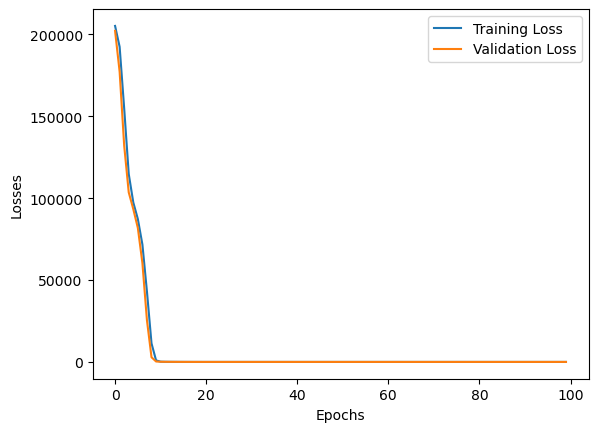

In [40]:
import matplotlib.pyplot as plt

loss_df = pd.DataFrame({
    "Training Loss": train_losses,
    "Validation Loss": val_losses
})

plt.plot(loss_df["Training Loss"], label = "Training Loss")
plt.plot(loss_df["Validation Loss"], label = "Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Losses")

plt.legend()

In [41]:
# Loading the best model
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [43]:
# Evaluation

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor)
    test_preds = model(X_test_tensor)

    train_mse_loss = crietrion(train_preds, y_train_tensor)
    test_mse_loss = crietrion(test_preds, y_test_tensor)

print("Training MSE:", train_mse_loss.item())
print("Testing MSE:", test_mse_loss.item())

Training MSE: 19.50849151611328
Testing MSE: 17.81768035888672


In [44]:
from sklearn.metrics import r2_score

print("r^2 score =", r2_score(y_test, test_preds))

r^2 score = 0.9377318056563166


In [45]:
predicted_df = pd.DataFrame(test_preds.numpy(), columns=["Predicted Values"])
actual_df = pd.DataFrame(y_test.values, columns=["Actual Values"])

pd.concat([predicted_df, actual_df], axis=1)

,Predicted Values,Actual Values
0,435.587799,433.27
1,435.921936,438.16
2,460.269989,458.42
3,476.763641,480.82
4,435.626129,441.41
...,...,...
1909,451.688629,456.70
1910,431.660950,438.04
1911,467.092468,467.80
1912,430.695496,437.14
